In [1]:
!nvidia-smi

Sat Jul 23 18:15:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:06:00.0 Off |                    0 |
| N/A   42C    P8    27W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           On   | 00000000:07:00.0 Off |                    0 |
| N/A   

In [1]:
%load_ext autoreload
%autoreload 2
    
import sys
sys.path.append("../") # go to parent dir

from muss_utils import (
    compute_features, 
    fetch_preprocessor_used_in_muss_model_training, 
    build_processor_combinations, 
    construct_multiple_training_instances,
    get_params_as_dict,
    strip_params,
    build_processor_values,
)

from utils import *

from transformers import BartForConditionalGeneration, BartTokenizer, AutoTokenizer, AutoModel, utils
from nltk.metrics.distance import edit_distance
from string import Template
import numpy as np
import math
import random
# from itertools import combinations
import itertools
import torch
from pathlib import Path
import os
from typing import List, Tuple
import warnings
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
GPU = "15"
os.environ["CUDA_VISIBLE_DEVICES"] = GPU

if torch.cuda.is_available():    
    print(torch.cuda.current_device())
    print(torch.cuda.device)
    torch.cuda.device = GPU
    print(torch.cuda.device)
    device = 'cuda'
else:
    device = 'cpu'
print(f'device: {device}')

device: cpu


In [3]:
# set to true to run generation
overwite = False

In [4]:
# Initialize tokenizer and model. Be sure to set output_attentions=True.
# Load BART fine-tuned for summarization on CNN/Daily Mail dataset
if overwite:
    model_path = "/scratch/tkew/ctrl_tokens/resources/models/muss_en_mined_hf"
    tokenizer = BartTokenizer.from_pretrained(model_path)
    model = BartForConditionalGeneration.from_pretrained(model_path, output_attentions=True)
    model = model.eval()
    model = model.to(device)

In [16]:
SEED = 4
batch_size = 24
sample = True
# sample_size = 0.01
sample_size = 30000
params_range = "id" # ood
# params_range = "ood"
# dataset = 'examples.en' # 
dataset = 'asset_test' # 320

if dataset.startswith('asset'):
    file = f'/scratch/tkew/ctrl_tokens/resources/data/en/aligned/{dataset}.tsv'    
# elif dataset.startswith('turk'):
#     file = f'/scratch/tkew/ctrl_tokens/resources/data/en/aligned/{dataset}.tsv'    
elif dataset == 'examples.en':
    file = f'/scratch/tkew/ctrl_tokens/resources/data/{dataset}'    
    
outfile = Path(f'../results/muss_params_and_attrs_on_{dataset}_{sample_size}_{params_range}params.json')
print(outfile)


../results/muss_params_and_attrs_on_asset_test_30000_idparams.json


In [17]:
preprocessors = fetch_preprocessor_used_in_muss_model_training()

Loaded preprocessors: [LengthRatioPreprocessor(target_ratio=0.8, use_short_name=False), ReplaceOnlyLevenshteinPreprocessor(bucket_size=0.05, noise_std=0, target_ratio=0.8, use_short_name=False), WordRankRatioPreprocessor(language='en', target_ratio=0.8, use_short_name=False), DependencyTreeDepthRatioPreprocessor(language='en', target_ratio=0.8, use_short_name=False)]


In [18]:

# set based on distribution of values in training data
if params_range == "id":
    min_max_step_vals = {
        'LENGTHRATIO': (0.7, 1.2, 0.05), 
        'REPLACEONLYLEVENSHTEIN': (0.5, 1.0, 0.05), 
        'WORDRANKRATIO': (0.7, 1.2, 0.05), 
        'DEPENDENCYTREEDEPTHRATIO': (0.5, 1.5, 0.05),
    }

elif params_range == "ood":
    min_max_step_vals = {
        'LENGTHRATIO': (0.25, 1.26, 0.25),
        'REPLACEONLYLEVENSHTEIN': (0.25, 1.26, 0.25),
        'WORDRANKRATIO': (0.25, 1.26, 0.25),
        'DEPENDENCYTREEDEPTHRATIO': (0.25, 1.26, 0.25),
    }


param_combinations = build_processor_combinations(preprocessors, min_max_step_vals, verbose=True)

Possible params:
[['<DEPENDENCYTREEDEPTHRATIO_0.5>', '<DEPENDENCYTREEDEPTHRATIO_0.55>', '<DEPENDENCYTREEDEPTHRATIO_0.6>', '<DEPENDENCYTREEDEPTHRATIO_0.65>', '<DEPENDENCYTREEDEPTHRATIO_0.7>', '<DEPENDENCYTREEDEPTHRATIO_0.75>', '<DEPENDENCYTREEDEPTHRATIO_0.8>', '<DEPENDENCYTREEDEPTHRATIO_0.85>', '<DEPENDENCYTREEDEPTHRATIO_0.9>', '<DEPENDENCYTREEDEPTHRATIO_0.95>', '<DEPENDENCYTREEDEPTHRATIO_1.0>', '<DEPENDENCYTREEDEPTHRATIO_1.05>', '<DEPENDENCYTREEDEPTHRATIO_1.1>', '<DEPENDENCYTREEDEPTHRATIO_1.15>', '<DEPENDENCYTREEDEPTHRATIO_1.2>', '<DEPENDENCYTREEDEPTHRATIO_1.25>', '<DEPENDENCYTREEDEPTHRATIO_1.3>', '<DEPENDENCYTREEDEPTHRATIO_1.35>', '<DEPENDENCYTREEDEPTHRATIO_1.4>', '<DEPENDENCYTREEDEPTHRATIO_1.45>'], ['<WORDRANKRATIO_0.7>', '<WORDRANKRATIO_0.75>', '<WORDRANKRATIO_0.8>', '<WORDRANKRATIO_0.85>', '<WORDRANKRATIO_0.9>', '<WORDRANKRATIO_0.95>', '<WORDRANKRATIO_1.0>', '<WORDRANKRATIO_1.05>', '<WORDRANKRATIO_1.1>', '<WORDRANKRATIO_1.15>'], ['<REPLACEONLYLEVENSHTEIN_0.5>', '<REPLACEONLYLEVENSH

In [19]:
if not outfile.exists() or overwite:
    print('Running Generations...')
    
    src_sentences = []
    for line in read_lines(file):
        for src_sent in construct_multiple_training_instances(line, param_combinations):
            src_sentences.append(src_sent)

    print(f'Constructed {len(src_sentences)} sentences with ACCESS/MUSS control tokens')
    print(src_sentences[:5])
    
    if sample:
        if isinstance(sample_size, float):
            random.seed(SEED)
            src_sentences = random.sample(src_sentences, int(len(src_sentences)*sample_size))
        elif isinstance(sample_size, int):
            random.seed(SEED)
            src_sentences = random.sample(src_sentences, sample_size)    
        
        print(f'Sampled {len(src_sentences)} sentences with ACCESS/MUSS control tokens')
        print(src_sentences[:5])
        
    with open(outfile, 'w', encoding='utf8') as outf:
        for batch_inputs in tqdm(batch(src_sentences, batch_size), total=len(src_sentences)/batch_size):
            batch_preds = generate(batch_inputs, model, tokenizer)    

            for src, pred in zip(batch_inputs, batch_preds):

                data = {
                    'src': strip_params(src, preprocessors),
                    'params': get_params_as_dict(src, preprocessors),
                    'pred': pred.strip(),
                    'attr': compute_features(src, pred, preprocessors, as_score=True),
                }

                outf.write(f'{json.dumps(data)}\n')

In [20]:
if outfile.exists():
    data = []
    with open(outfile, 'r', encoding='utf8') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    df = pd.json_normalize(data)

print(df.columns)
df = df.drop(columns=['attr.LengthRatio_score', 'attr.ReplaceOnlyLevenshtein_score', 'attr.WordRankRatio_score', 'attr.DependencyTreeDepthRatio_score'])
df.head()

Index(['src', 'pred', 'params.DEPENDENCYTREEDEPTHRATIO',
       'params.WORDRANKRATIO', 'params.REPLACEONLYLEVENSHTEIN',
       'params.LENGTHRATIO', 'attr.LengthRatio_score', 'attr.LENGTHRATIO',
       'attr.ReplaceOnlyLevenshtein_score', 'attr.REPLACEONLYLEVENSHTEIN',
       'attr.WordRankRatio_score', 'attr.WORDRANKRATIO',
       'attr.DependencyTreeDepthRatio_score', 'attr.DEPENDENCYTREEDEPTHRATIO'],
      dtype='object')


,src,pred,params.DEPENDENCYTREEDEPTHRATIO,params.WORDRANKRATIO,params.REPLACEONLYLEVENSHTEIN,params.LENGTHRATIO,attr.LENGTHRATIO,attr.REPLACEONLYLEVENSHTEIN,attr.WORDRANKRATIO,attr.DEPENDENCYTREEDEPTHRATIO
0,Mifepristone is a synthetic steroid compound u...,Mifepristone is a synthetic steroid drug which...,0.50,0.75,0.55,0.90,0.45,0.70,1.0,1.00
1,"The wave traveled across the Atlantic, and org...","The wave moved across the Atlantic, formed int...",0.70,0.80,0.75,0.80,0.50,0.95,1.0,0.70
2,Orton and his wife welcomed Alanna Marie Orton...,"Orton and his wife welcomed their daughter, Al...",0.75,0.90,0.55,1.15,0.60,1.00,1.1,1.35
3,The body color varies from medium brown to gol...,The body color varies from medium brown to bei...,1.00,0.70,0.50,0.95,0.65,0.85,1.0,1.50
4,You may add a passage of up to five words as a...,You may add a passage of up to five words as a...,0.60,0.85,0.85,1.05,0.80,0.95,0.9,1.20


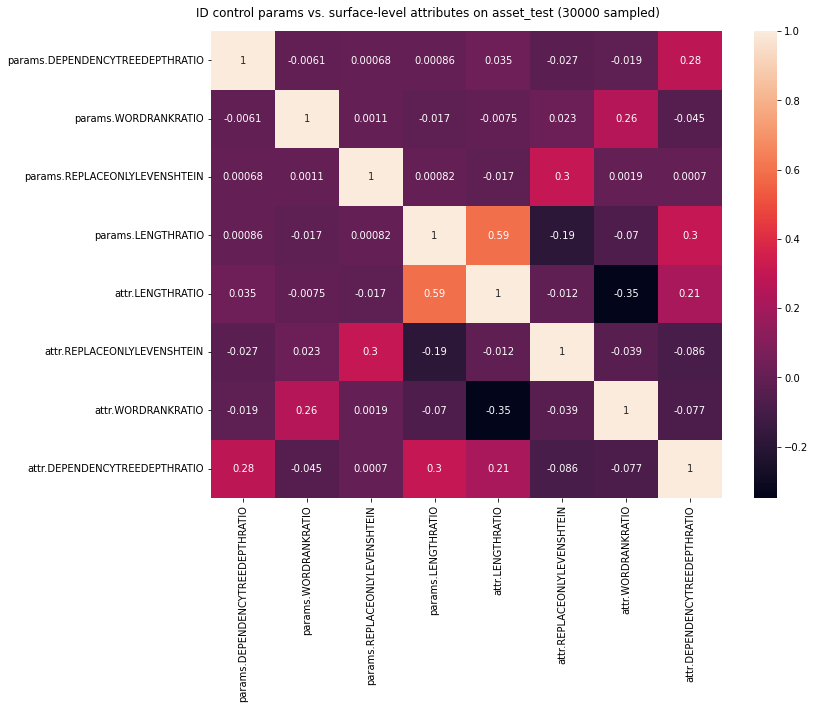

In [21]:
# plt.figure(figsize=(10, 8))
fig, axes = plt.subplots(1, 1, figsize=(12,10), sharey=True)
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.

corr = df.corr()
heatmap = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True,
        ax=axes)

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
# heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

fig.suptitle(f'{params_range.upper()} control params vs. surface-level attributes on {dataset} ({sample_size} sampled)')
fig.tight_layout()
plt.savefig(f'../results/plots/surface_level_correlation_{dataset}_{sample_size}_{params_range}params.png', dpi=300)


In [22]:
print(df[['params.LENGTHRATIO', 'attr.LENGTHRATIO']].corr())
print()
print(df[['params.REPLACEONLYLEVENSHTEIN', 'attr.REPLACEONLYLEVENSHTEIN']].corr())
print()
print(df[['params.WORDRANKRATIO', 'attr.WORDRANKRATIO']].corr())
print()
print(df[['params.DEPENDENCYTREEDEPTHRATIO', 'attr.DEPENDENCYTREEDEPTHRATIO']].corr())

                    params.LENGTHRATIO  attr.LENGTHRATIO
params.LENGTHRATIO            1.000000          0.594134
attr.LENGTHRATIO              0.594134          1.000000

                               params.REPLACEONLYLEVENSHTEIN  \
params.REPLACEONLYLEVENSHTEIN                       1.000000   
attr.REPLACEONLYLEVENSHTEIN                         0.301362   

                               attr.REPLACEONLYLEVENSHTEIN  
params.REPLACEONLYLEVENSHTEIN                     0.301362  
attr.REPLACEONLYLEVENSHTEIN                       1.000000  

                      params.WORDRANKRATIO  attr.WORDRANKRATIO
params.WORDRANKRATIO               1.00000             0.25684
attr.WORDRANKRATIO                 0.25684             1.00000

                                 params.DEPENDENCYTREEDEPTHRATIO  \
params.DEPENDENCYTREEDEPTHRATIO                         1.000000   
attr.DEPENDENCYTREEDEPTHRATIO                           0.279791   

                                 attr.DEPENDENCYTREEDEPT